In [4]:
from torchsummary import summary
from datetime import datetime
import torch.nn as nn
import torch
import random
import numpy as np

from src.nn.regression_dataset import RegressionDataset
from src.nn.to_tensor import ToTensor
from src.nn.create_data_loaders import create_data_loaders
from src.nn.cnn_regressor import CNNRegressor
from src.nn.training import training
from src.nn.plot_losses import plot_losses
import src.ctes.num_ctes as nctes
import src.ctes.path_ctes as pctes

In [5]:
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [6]:
data_path = pctes.DATAPATH
transform = ToTensor()
sample_size = nctes.LEN_SAMPLE

data = RegressionDataset(data_path, transform, sample_size)

In [7]:
batch_size = 6
valid_size = 0.2
test_size = 0.2

train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, test_size, data)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device ' + str(device))

Using device cuda


In [9]:
sample_size = nctes.LEN_SAMPLE
model = CNNRegressor(input_size=sample_size)
model.to(device=device)

summary(model, (1, sample_size))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 32768]           --
|    └─Conv1d: 2-1                       [-1, 16, 32768]           16
|    └─BatchNorm1d: 2-2                  [-1, 16, 32768]           32
|    └─ReLU: 2-3                         [-1, 16, 32768]           --
├─Dropout: 1-2                           [-1, 16, 32768]           --
├─Sequential: 1-3                        [-1, 32, 32767]           --
|    └─Conv1d: 2-4                       [-1, 32, 32767]           1,024
|    └─BatchNorm1d: 2-5                  [-1, 32, 32767]           64
|    └─ReLU: 2-6                         [-1, 32, 32767]           --
├─AvgPool1d: 1-4                         [-1, 32, 16384]           --
├─Dropout: 1-5                           [-1, 32, 16384]           --
├─Sequential: 1-6                        [-1, 64, 16381]           --
|    └─Conv1d: 2-7                       [-1, 64, 16381]           8,192
|    └─Ba

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 32768]           --
|    └─Conv1d: 2-1                       [-1, 16, 32768]           16
|    └─BatchNorm1d: 2-2                  [-1, 16, 32768]           32
|    └─ReLU: 2-3                         [-1, 16, 32768]           --
├─Dropout: 1-2                           [-1, 16, 32768]           --
├─Sequential: 1-3                        [-1, 32, 32767]           --
|    └─Conv1d: 2-4                       [-1, 32, 32767]           1,024
|    └─BatchNorm1d: 2-5                  [-1, 32, 32767]           64
|    └─ReLU: 2-6                         [-1, 32, 32767]           --
├─AvgPool1d: 1-4                         [-1, 32, 16384]           --
├─Dropout: 1-5                           [-1, 32, 16384]           --
├─Sequential: 1-6                        [-1, 64, 16381]           --
|    └─Conv1d: 2-7                       [-1, 64, 16381]           8,192
|    └─Ba

In [10]:
criterion = nn.MSELoss()
print(criterion)

MSELoss()


In [11]:
params = model.parameters()
lr = 0.001

optimizer = torch.optim.Adam(params, lr)
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [12]:
n_epochs = 2

In [13]:
timestamp = datetime.now().strftime('%Y_%m_%d__%H_%M_%S')
hyperparams_path = f"../../data/hyperparams_{timestamp}.npz"
model_path = f"../../data/model_{timestamp}.pt"
losses_path = f"../../data/losses_{timestamp}.npz"

In [14]:
np.savez(hyperparams_path, 
         len=len(data), 
         test_size=test_size, 
         valid_size=valid_size, 
         epochs=n_epochs, 
         batch_size=batch_size, 
         criterion=str(criterion), 
         optimizer=str(optimizer), 
         lr=lr,
         seed=seed)

In [15]:
train_losses, valid_losses = training(n_epochs, train_loader, valid_loader, model, criterion, optimizer, device, model_path)

Epoch 1/2 ...
Training ...


  0%|          | 0/1366 [00:00<?, ?it/s]

100%|██████████| 1366/1366 [02:40<00:00,  8.52it/s]


Validating ...


100%|██████████| 342/342 [00:13<00:00, 25.85it/s]


Epoch: 1 	training Loss: 0.126666 	validation Loss: 0.110450
Validation loss decreased (inf --> 0.110450).  Saving model ...
Epoch 2/2 ...
Training ...


100%|██████████| 1366/1366 [02:40<00:00,  8.49it/s]


Validating ...


100%|██████████| 342/342 [00:13<00:00, 25.82it/s]

Epoch: 2 	training Loss: 0.106130 	validation Loss: 0.159372


In [16]:
np.savez(losses_path , train=np.array(train_losses), val=np.array(valid_losses))

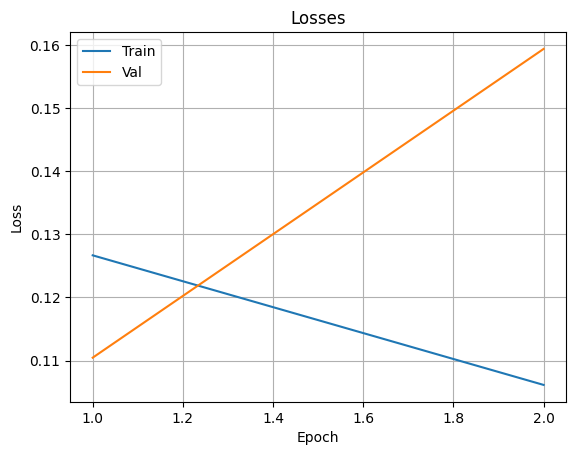

In [17]:
plot_losses(len(train_losses), [train_losses, valid_losses], ["Train", "Val"])